## Data Preprocessing

In [12]:
import pandas as pd 
import numpy as np 
import mysql.connector
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Fetching data from database...


C:\Users\A\AppData\Local\Temp\ipykernel_1388\70760937.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df= pd.read_sql(query, connection)


Data fetched successfully!
Preprocessing data...
Data preprocessing complete!
Detecting anomalies...
Anomaly detection complete!
   id      size  protocol_Ethernet  protocol_IP  protocol_TCP  flag_A  \
0  81  0.052174               True        False         False   False   
1  82  0.052174              False         True         False   False   
2  83  0.052174              False        False          True    True   
3  84  0.995652               True        False         False   False   
4  85  0.995652              False         True         False   False   

   flag_None  flag_PA  anomaly  
0       True    False   Normal  
1       True    False   Normal  
2      False    False  Anomaly  
3       True    False   Normal  
4       True    False   Normal  
Visualizing anomalies...


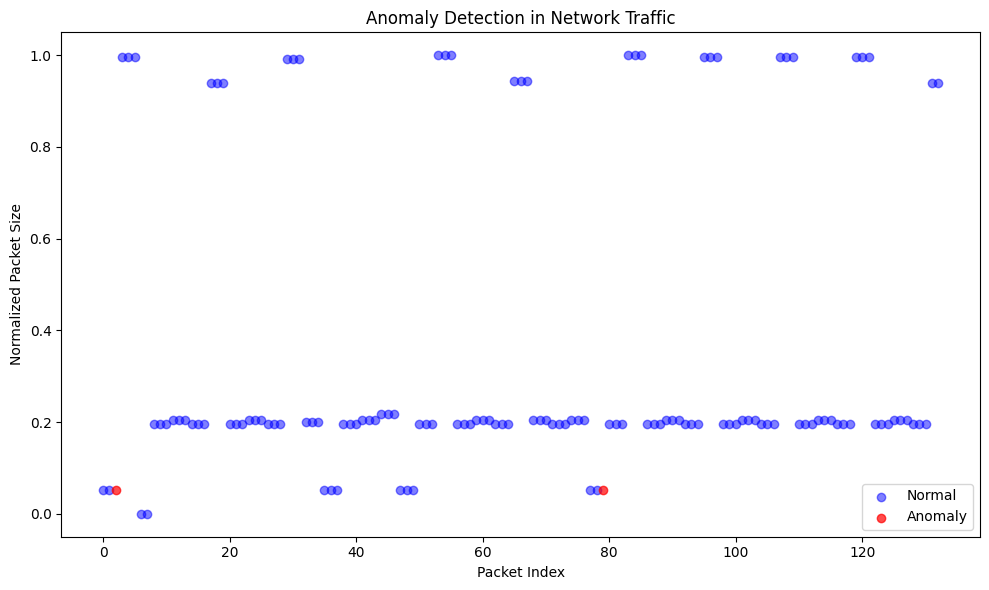

In [14]:
#connect to database
def fetch_data():
    connection=mysql.connector.connect(
        charset="utf8mb4",
        connection_timeout=10,
        database="defaultdb",
        host="mysql-f3601b9-jonesjorney-bd4e.f.aivencloud.com",
        password="AVNS_ERXe8j5gIX5yis97hnw",
        port=21038,
        user="avnadmin"

    )

    #query the data
    query="SELECT * FROM events"
    df= pd.read_sql(query, connection)
    connection.close()

    #Inspect the data
    return df

#Preprocess data
def preprocess_data(df):
    # Convert protocol to numeric
    df = pd.get_dummies(df, columns=['protocol'])
    
    # Convert flags to numeric using one-hot encoding
    # First fill NaN values with 'None'
    df['flags'] = df['flags'].fillna('None')
    df = pd.get_dummies(df, columns=['flags'], prefix='flag')
    
    # Normalize the 'size' column
    scaler = MinMaxScaler()
    df['size'] = scaler.fit_transform(df[['size']])

    # Drop non-numeric columns
    df = df.drop(['timestamp', 'src', 'dest'], axis=1)
    return df


# Anomaly Detection with Isolation Forest
def detect_anomalies(df):
    model=IsolationForest(contamination=0.01, random_state=42)
    df['anomaly']=model.fit_predict(df)

    #Mark anomalies (-1) and normal(1) packets
    df['anomaly']=df['anomaly'].apply(lambda x: 'Anomaly' if x==-1 else 'Normal')
    return df

 

# Visualization
def visualize_anomalies(df):
    """Visualize anomalies in the data."""
    anomalies = df[df['anomaly'] == 'Anomaly']
    normal = df[df['anomaly'] == 'Normal']

    plt.figure(figsize=(10, 6))
    plt.scatter(normal.index, normal['size'], label='Normal', c='blue', alpha=0.5)
    plt.scatter(anomalies.index, anomalies['size'], label='Anomaly', c='red', alpha=0.7)
    plt.title("Anomaly Detection in Network Traffic")
    plt.xlabel("Packet Index")
    plt.ylabel("Normalized Packet Size")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main Function
if __name__ == "__main__":
    # Fetch data from the database
    print("Fetching data from database...")
    df = fetch_data()
    print("Data fetched successfully!")

    # Preprocess the data
    print("Preprocessing data...")
    processed_df = preprocess_data(df)
    print("Data preprocessing complete!")

    # Detect anomalies
    print("Detecting anomalies...")
    result_df = detect_anomalies(processed_df)
    print("Anomaly detection complete!")
    print(result_df.head())  # Print the first few rows of the result

    # Visualize the results
    print("Visualizing anomalies...")
    visualize_anomalies(result_df)


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Replace 'Anomaly' with 1 and 'Normal' with 0 for evaluation
result_df['anomaly'] = result_df['anomaly'].apply(lambda x: 1 if x == 'Anomaly' else 0)

# Assuming the ground truth labels are available in a column named 'true_labels'
# For demonstration, let's create a dummy true_labels column
result_df['true_labels'] = np.random.choice([0, 1], size=len(result_df), p=[0.99, 0.01])

# Compute the confusion matrix
cm = confusion_matrix(result_df['true_labels'], result_df['anomaly'])
print("Confusion Matrix:")
print(cm)

# Print classification report
cr = classification_report(result_df['true_labels'], result_df['anomaly'])
print("\nClassification Report:")
print(cr)

Confusion Matrix:
[[131   2]
 [  0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       133
           1       0.00      0.00      0.00         0

    accuracy                           0.98       133
   macro avg       0.50      0.49      0.50       133
weighted avg       1.00      0.98      0.99       133



c:\Users\A\.vscode\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A\.vscode\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A\.vscode\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


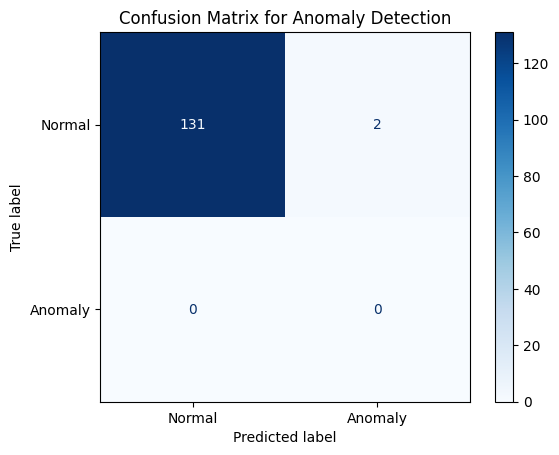

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()